In [1]:
from egnn_pytorch import EGNN_Network

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F
import itertools

import torch
from matplotlib import pyplot as plt
import glob

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from collections import defaultdict
import dask.dataframe as dd

charges = {'HIS': 1, 'LYS': 1,
           'ASP': -1, 'GLU': -1,  # carboxylate
           'CYS': 0,
           'TYR': 0}   # thiol and phenol prot

cations = {'HIS': ("HD1", "HD2", "HE1", "HE2"),
        'ASP':None,
        "LYS":("HZ1", "HZ2","HZ3"),
        "TYR":"HH",
        "GLU":None,
        "CYS":'HG',
        "ARG": ("HE11","HE12", "HE21", "HE22"),
        "THR":"HG1",
        "SER":"HG",
        "TRP":"HE1"}


anions = {"HIS":("ND1", "ND2"),
          "ASP":("OD1","OD2"),
          "LYS":"NZ",
          "TYR":"OH",
          "GLU":("OE1", "OE2"),
          "CYS":"SG",
          "ARG": ("NE1","NE2"),
          "THR":"OG1",
          "SER":"OG",
          "TRP":"NE1"}

prot = charges.keys()

directory = "/home/jrhoernschemeyer/Desktop/thesis/"


def load_pdb(path):
    solvents, counter = {}, 0
    with open(path, "r") as f:
        resis, xs, counter = {}, [], 0
        for line in f:
            L = line.split()

            if line.startswith("ATOM"):
                resname, atomname = L[3], L[2]
                if resname in charges.keys():
                    resname = resname + str(L[5]) + L[4]

                    if resname in resis:
                        resis[resname][f"{atomname} {counter}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1
                    else:
                        resis[resname] = {f"{atomname} {counter}": (float(L[6]), float(L[7]), float(L[8]))}
                        counter += 1

                else:  # resname in noprot
                    resname, atomname = L[3], L[2]
                    xs.append((float(L[6]), float(L[7]), float(L[8])))
                    counter += 1

            elif line.startswith("HETATM"):
                resname = L[3] + str(L[5])
                atomname = L[2]
                if resname in solvents:
                    solvents[resname][f"{atomname} {str(counter)}"] = (float(L[6]), float(L[7]), float(L[8]))
                    counter += 1
                else:
                    solvents[resname] = {f"{atomname} {str(counter)}": (float(L[6]), float(L[7]), float(L[8]))}
                counter += 1
    
    return resis


def get_pdbs_labels(directory):
    """gets the data dictionary and [pdb string names] 

    inputs: path to directory where input structures are saved"""
    pdbids, data =[],{}
    
    for file in glob.glob(directory + "/PDB/*red.pdb"):
        pdbid = file[-12:-8]
        data[pdbid] = load_pdb(file)
        pdbids.append(pdbid)
    
   

    return data, dd.read_csv(directory + "/pkas.csv", sep=';'), pdbids


def get_targets(df):
    #targets = defaultdict(list)
    targets={}
    for item in df:
        num, resi, chain, pk = item['residue_number'], item['residue_name'], item["chain"], item["pk"]
        targets[resi+str(num)+chain]= pk 

        
    
    return targets

def get_data(pdbs, df, data):
    """returns dictionary of data with pdbids as keys and residueid indexed positions, atomic node and species information, input features (hydrogen indices), and the number of atoms in each sample (residue).
    all_species: {199l: {ASP1A : {CA:1} , ..., {TYR100 : {OXT:1032} } """
    
    all_pos, all_species, all_lengths, all_feats, all_targets, all_ions = {},{},{},{}, {}, {}

    counter=0


    for pdb in pdbs:
        resis = data[pdb] #for one protein
        lengths, species, feats, R ={}, {}, {}, {}
        
        for resid, vals in resis.items():
            hindices = []
            counter=0
            resi_pos, resi_species ={},{}
            
            for atom, pos in vals.items():
                node = atom.split()  # name, pos
                name, nodei =node[0], int(node[1])

                if name[0] == 'H':
                    hindices.append(counter)

                resi_pos[counter] = pos
                resi_species[name] = counter

                counter +=1
            

            f = torch.zeros(counter)        
            f[hindices] = 1
            feats[resid] = f #hydrogen indices

            species[resid] = resi_species 
            R[resid] = resi_pos

            lengths[resid] = counter #num atoms of a sample (resi)

        all_pos[pdb]= R
        all_species[pdb] = species
        all_lengths[pdb] = lengths
        all_feats[pdb] = feats

        #get labels
        d = df[df.iloc[:, 0] == pdb].drop(columns = ["idcode"])
        all_targets[pdb] = get_targets(d.compute().to_dict(orient="records"))

        def ionic_features(pdb, all_ions):

            pdb_ions={}
            Ls = all_lengths[pdb]

            
            for resi in data[pdb].keys():
                resi_species = (all_species[pdb])[resi]
                ion = torch.zeros(Ls[resi])
                resname = resi[:3]
                idxs = [resi_species.get(a) for a in anions[resname]] 
                ion[idxs]= -1
                
                cats = cations[resname]
                if cats:
                    cs = [c for c in cats if c is not None]
                    cats =[resi_species.get(a) for a in cs]
                    cs = [c for c in cats if c is not None]
                    ion[cs] = 1
                pdb_ions[resi] = ion
                
            return pdb_ions
        
        all_ions[pdb] = ionic_features(pdb, {})

    dicts = (all_ions, all_feats, all_pos, all_lengths, {k: v for k, v in all_targets.items() if not k.startswith('N') or k.startswith("CT")})
    titles = ["ions", "Hs", "pos", "L", "targets"]

# Initialize a defaultdict of dicts
    all_data = defaultdict(dict)

# Merge dictionaries with titles
    for title, d in zip(titles, dicts):
        for key, value in d.items():
            all_data[key][title] = value

    return all_data


def boltzmax(x, temp):
    """
    Computes Boltzmann probabilities (Euclidean Softmax) for a tensor of distances.
    
    Parameters:
        distances (torch.Tensor): feature tensor
        temperature (float): The temperature parameter to control the sharpness.
    
    Returns:
        torch.Tensor: A tensor of notprobabilities 
    """
    # Scale the distances by temperature
    scaled_distances = x / temp
    
    # Exponentiate the scaled distances
    x = torch.exp(scaled_distances)
    p = x / torch.max(x) #doing max instead of 
    
    return p


def contrastive_loss(latent_features, species):
    """seperates latent space by enforcing dissimilarity between negative and positive ions"""

    loss = 0.0

    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]
    negative_pairs = [(i, j) for i, j in itertools.combinations(range(3), 2) if species[i] != species[j]]


    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)  
        loss += dist ** 2  

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2) 
        loss += torch.clamp(dist, min=0) ** 2 #min 0 was the margin enforcement



    return loss / (len(positive_pairs) + len(negative_pairs))



def model1(num_nodes, dim, depth, lr, weight_decay):
    net = EGNN_Network(
        num_tokens = 100, #vocabulary siye, "number of unique species"
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = dim,
        depth=depth,
        num_nearest_neighbors = 1, 
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    return net, optimizer

def model2():
    pnet = EGNN_Network(
            num_tokens = 50, #vocabulary siye, number of unique species
            num_positions = 23,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
            dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
            depth = 3, #number of layers #deeper need more memort to store intermediate reps
            num_nearest_neighbors = 6, #number of nearest neighbors to consider
            dropout=.05,
            m_pool_method='mean')

    return pnet, torch.optim.Adam(pnet.parameters(), lr=.01, weight_decay=.1)


def loop(nepochs, coors, Hs, ion_labels, model, optimizer, negative_slope):
    """run model1"""
    for epoch in range(nepochs):
        optimizer.zero_grad()
        x, _ = model(Hs.unsqueeze(0), coors.unsqueeze(0)) #can turn off return po
        rep = boltzmax((nn.LeakyReLU(negative_slope=negative_slope)(x)), 15)[0] #apply activation (output raw numbers), and softmax (output nonnormalized probabilities)  
        L = contrastive_loss(rep, ion_labels)
        L.backward()
        optimizer.step()

    return rep


import math
import torch
import torch.nn as nn

# Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        # In self-attention, query, key, and value are all the same.
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs#, attn_weights


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data, df, pdbs = get_pdbs_labels(directory)

all_data = get_data(pdbs, df, data)

In [3]:
#run model 1

Ds = {}
for pdb in pdbs:
    print(pdb)
    ds={}

    d = all_data[pdb]
    pos, hs, ions = d["pos"], d["Hs"], d["ions"]#, d["targets"]
    
    
    for sample in pos.keys():
        net, optimizer1 = model1(23, 3, 2, .01, .01) # dim, depth, lr, weight decay #reinit each time lol
        coords = torch.tensor(tuple(pos[sample].values()))
        #L = coords.shape[0]
        x = loop(1, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer1, 1) #1 epoch
        y=torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T

        ds[sample] = np.gradient(np.gradient(np.column_stack(y).flatten())).reshape(-1,3)
    
    Ds[pdb] = ds #laplacians



        

10gs


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
104l


In [4]:
Ds

{'10gs': {'TYR3A': array([[25.324776 , 16.446905 , -8.830338 ],
         [-3.8126798, 12.838171 , -8.216717 ],
         [-3.9268942, 11.951819 , -8.221558 ],
         [-3.6436849, 11.477259 , -8.475338 ],
         [-2.8134599, 11.785431 , -9.472319 ],
         [-2.794663 , 12.845688 , -9.158798 ],
         [-4.138518 , 11.900459 , -7.8117547],
         [-3.5757527, 11.667225 , -7.5936384],
         [-3.8943958, 11.686974 , -7.5882215],
         [-4.5414925, 12.192682 , -6.426497 ],
         [-5.0735497, 10.579166 , -6.9490786],
         [-4.0883117, 11.281705 , -7.2423925],
         [-4.4912796, 12.142072 , -7.1446557],
         [-5.117866 , 12.673229 , -6.587878 ],
         [-5.7838597, 11.648526 , -5.9266553],
         [-5.470226 , 10.872534 , -6.705461 ],
         [-5.0583014, 12.616141 , -6.6078386],
         [-6.093578 , 12.551729 , -6.0491905],
         [-6.073524 , 12.174015 , -5.975821 ],
         [-6.457953 , 11.291922 , -5.5840607],
         [-5.7761   , 15.964336 , 20.926521

In [532]:
pdbs = ["109l","111m","110m","108m",
"110l",
"109m",
"111l",
"108l",
"104m",
"106m",
"105m",
"103m",
"107m",
"107l",
"103l",
"102m",
"102l"] + ["104l","101m"]

In [7]:
A=PositionalEncoding(22)()
A

PositionalEncoding(
  (dropout): Dropout(p=0.1, inplace=False)
)

In [1879]:
pdbs = random.sample(pdbs, len(pdbs))
pdbs

['105m',
 '103l',
 '110m',
 '107m',
 '107l',
 '103m',
 '109l',
 '104m',
 '10gs',
 '106m',
 '110l',
 '101m',
 '111m',
 '104l',
 '109m',
 '108l',
 '111l',
 '108m',
 '102m',
 '102l']

In [17]:
A(torch.tensor(list(Ds["10gs"].values())[0]))

RuntimeError: The size of tensor a (3) must match the size of tensor b (22) at non-singleton dimension 2

In [8]:
#pdbs = random.sample(pdbs, len(pdbs))
#print(shuffled_list)  # A new shuffled list
mha = SimpleMultiheadAttention(22, 1)
import random
#mha = SimpleMultiheadAttention(22, 1)
A = PositionalEncoding(22)

def model2():

    pnet = EGNN_Network(
            num_tokens = 3, #vocabulary siye, number of unique species
            num_positions = 23,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
            dim = 2, #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
            depth = 3, #number of layers #deeper need more memort to store intermediate reps
            num_nearest_neighbors = 2, #number of nearest neighbors to conside1
            dropout=0.05,
            m_pool_method='mean')

    return pnet, torch.optim.Adam(pnet.parameters(), lr=.0001, weight_decay=.01)


outs2={}
losses={}
pnet, optimizer3 = model2()
fails={}
optimizer3 = torch.optim.Adam(
    list(pnet.parameters()) + list(mha.parameters()),
    lr=0.0001, weight_decay=.01)
#{}
#def run_m2(pdbs, all_data):
nepochs=97


results, vresults ={},{}
for i in range(nepochs):
    #print(f"starting loop {i}")
    results[i]=[]
    vresults[i] = []
    
    
    for pdb in pdbs[:16]:
        
        #if pdb not in fails:
        ##fails[pdb] = []
        ##outie = {}
        #print(pdb)
        Ddict = Ds[pdb]
    

        d = all_data[pdb]
        pos, T = d["pos"], d["targets"]
        #a=list(T.values())
        #a.sort()
        #print(a)

        
        #l = list(pos.keys())
        samples = random.sample(list(pos.keys()), len(pos))


        for sample in pos.keys():

            coords = torch.tensor(np.gradient(np.gradient(torch.tensor(tuple(pos[sample].values())))))
            D=torch.tensor(Ddict[sample])
            

        

            loss = torch.nn.HuberLoss()

            ins = torch.ones(coords[0].shape[1], dtype=int)
            ins[0]=0.
            ins[-1] = 2.#first index 0, all other atoms have index 1, terminal side chain atom has index 2
            resname=sample[:3]
            label=T.get(resname + sample[3:-1].strip("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + sample[-1])


            if not label:
                label = T.get(resname + str(int(sample [3:-1].strip("ABCDEFGHIJKLMNOPQRSTUVWXYZ")) - 1) + sample[-1])
                
            if not label:
                continue
                #label = float(np.random.randn(1))

            


            optimizer3.zero_grad()

            y=(pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0])#, dim=-1)
            
            

            x=y[0].unsqueeze(1).unsqueeze(2)

            #mha = SimpleMultiheadAttention(1, 1)
            #output = mha(x
            output = mha(A(y[0].unsqueeze(2)))



            
            #pred=torch.max(torch.mean(output, dim=-0))
            #pred = 10**torch.log((1+torch.abs(torch.sum(torch.sum(output[0],dim=-2))))) #torch.sum(output[0][0])/3
            #pred = torch.sum(torch.abs((torch.mean(y[0],dim=1))))
            #pred = torch.max(output[0][1::]) 
            #pred = torch.mean(torch.sum(y[0][:,0] - y[0][:,1])) - 7
            a=torch.sum(torch.mean(0.5*torch.sum(output,dim=-1),dim=1)) 
            pred=a+torch.sum((torch.mean(y[0],dim=-0)))#sum(torch.mean(y[0],dim=-1))
            #pred = torch.sum(torch.mean(0.5*torch.sum(output,dim=-1),dim=1)) #torch.mean(torch.sum(y[0][:,0] - y[0][:,1])) - 7
            #pred = torch.mean((sum(y[0]))) + 7
            #att = torch.stack([o[0][0] for o in output])
            #pred = torch.matmul(torch.tensor(y[0][:,0] * y[0][:,1]),att)
            #pred = torch.sum(att) * torch.mean(att)

            
            loss2=loss(pred, torch.tensor(label))
            

            results[i].append((pdb, sample, round(pred.detach().item(),4), label, round(loss2.item(), 5)))
            


            loss2.backward()

            
            optimizer3.step()


    print("finished one round")


    
    pdbs2 = pdbs[16::]
    
    for pdb in pdbs2:
        d = all_data[pdb]
        pos, T = d["pos"], d["targets"]
        Ddict = Ds[pdb]

        for sample in pos.keys():

            coords = torch.tensor(np.gradient(np.gradient(torch.tensor(tuple(pos[sample].values())))))
            D=torch.tensor(Ddict[sample])
            
            ins = torch.ones(coords[0].shape[1], dtype=int)
            ins[0]=0.
            ins[-1] = 2.#first index 0, all other atoms have index 1, terminal side chain atom has index 2
            resname=sample[:3]
            label=T.get(resname + sample[3:-1].strip("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + sample[-1])

            if not label:
                label = T.get(resname + str(int(sample [3:-1].strip("ABCDEFGHIJKLMNOPQRSTUVWXYZ")) - 1) + sample[-1])

            
            if not label:
                continue
                #label = float(np.random.randn(1))

            #y=10/(0.1 + 10**(torch.mean(pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0],dim=-1)))
            y=(pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0])#,dim=-1))
            x=A(y[0].unsqueeze(2))
        
            #mha = SimpleMultiheadAttention(1, 1)
            #output = mha(x
            output = mha(x)
            
            #output = x[0][-6::]
            #print(label)
            #pred = torch.mean(output[0][1::]) #one token for every pka, which is rep by 6 nodes
            #pred=torch.max(torch.mean(output, dim=0))
            #pred = torch.sum(output[0][0])/3
            #pred = 10**torch.log((1+torch.abs(torch.sum(torch.sum(output[0],dim=-2))))) #torch.sum(output[0][0])/3
            #pred = torch.mean(torch.sum(y[0][:,0] - y[0][:,1])) - 7
            #torch.mean(y[0],dim=1) #seems to tell about the resi species in both its mean and sum
            a=torch.sum(torch.mean(0.5*torch.sum(output,dim=-1),dim=1)) 
            pred=a+torch.sum((torch.mean(y[0],dim=-0)))#sum(torch.mean(y[0],dim=-1))
            #pred=sum(torch.mean(y[0],dim=-1))#pred = torch.sum(torch.mean(0.5*torch.sum(output,dim=-1),dim=1))
            #print(torch.mean(torch.abs((torch.mean(y[0],dim=1)))))
            #pred = torch.sum(torch.abs((torch.mean(y[0],dim=1))))
            #att = torch.stack([o[0][0] for o in output])
            #pred = torch.matmul(torch.tensor(y[0][:,0] * y[0][:,1]),att)
            #pred = torch.sum(att) * torch.mean(att)
            #print("")
            #print("")
            loss2=loss(pred, torch.tensor(label))

            print(sample)
            print(label)
            print(pred)
            print("")
            
            #outie[sample] = y
            vresults[i].append((pdb, sample, round(pred.detach().item(),4), label, round(loss2.item(), 5)))




/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


finished one round
GLU5A
2.17026
tensor(9.6097, grad_fn=<AddBackward0>)

GLU7A
2.11289
tensor(6.6719, grad_fn=<AddBackward0>)

HIS13A
6.316330000000001
tensor(8.6165, grad_fn=<AddBackward0>)

LYS17A
10.4738
tensor(3.0441, grad_fn=<AddBackward0>)

GLU19A
2.5851599999999997
tensor(9.1343, grad_fn=<AddBackward0>)

ASP21A
2.24728
tensor(9.4087, grad_fn=<AddBackward0>)

HIS25A
1.51429
tensor(7.1863, grad_fn=<AddBackward0>)

ASP28A
2.83166
tensor(5.5097, grad_fn=<AddBackward0>)

LYS35A
10.8763
tensor(3.7053, grad_fn=<AddBackward0>)

HIS37A
7.323189999999999
tensor(5.1404, grad_fn=<AddBackward0>)

GLU39A
3.28936
tensor(8.6962, grad_fn=<AddBackward0>)

GLU42A
4.22865
tensor(7.1353, grad_fn=<AddBackward0>)

LYS43A
11.9456
tensor(9.9900, grad_fn=<AddBackward0>)

ASP45A
2.8055
tensor(6.8232, grad_fn=<AddBackward0>)

LYS48A
11.2767
tensor(7.6189, grad_fn=<AddBackward0>)



/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


HIS49A
5.52289
tensor(4.6497, grad_fn=<AddBackward0>)

LYS51A
10.7983
tensor(9.5675, grad_fn=<AddBackward0>)

GLU53A
2.33478
tensor(8.3330, grad_fn=<AddBackward0>)

GLU55A
3.27515
tensor(7.6193, grad_fn=<AddBackward0>)

LYS57A
11.129000000000001
tensor(11.5273, grad_fn=<AddBackward0>)

GLU60A
3.6525199999999995
tensor(6.7272, grad_fn=<AddBackward0>)

ASP61A
2.50623
tensor(7.8624, grad_fn=<AddBackward0>)

LYS63A
10.4535
tensor(12.4942, grad_fn=<AddBackward0>)

LYS64A
10.4535
tensor(9.1015, grad_fn=<AddBackward0>)

LYS78A
11.5737
tensor(12.0423, grad_fn=<AddBackward0>)

LYS79A
11.5478
tensor(12.6666, grad_fn=<AddBackward0>)

LYS80A
11.5478
tensor(9.0205, grad_fn=<AddBackward0>)

HIS82A
5.54
tensor(7.3231, grad_fn=<AddBackward0>)

HIS83A
5.54
tensor(6.1771, grad_fn=<AddBackward0>)

GLU84A
2.61539
tensor(6.3148, grad_fn=<AddBackward0>)

GLU86A
2.36996
tensor(6.7706, grad_fn=<AddBackward0>)

LYS88A
10.6318
tensor(11.8232, grad_fn=<AddBackward0>)

HIS94A
5.422999999999999
tensor(8.5160, grad

KeyboardInterrupt: 

In [29]:
y[0].unsqueeze(2).shape
#y[0].shape
#y#[0]
#A(y[0].unsqueeze(2))

torch.Size([17, 2, 1])

In [72]:
A=PositionalEncoding(1)

In [ ]:
A(y[0].unsqueeze(2)),dim=1),dim=-1)

In [78]:

y[0].unsqueeze(2).shape

torch.Size([17, 2, 1])

In [102]:
A=PositionalEncoding(100)
mha=SimpleMultiheadAttention(100,1)
(A(y[0].unsqueeze(2)))

tensor([[[ 0.5697,  1.6808,  0.5697,  ...,  1.6808,  0.5697,  1.6808],
         [-0.6457,  0.4654, -0.6457,  ...,  0.4654, -0.6457,  0.4654]],

        [[ 4.6255,  4.2909,  4.5118,  ...,  4.8017,  3.6907,  4.8017],
         [ 2.7036,  2.3690,  2.5899,  ...,  2.8797,  1.7688,  2.8797]],

        [[ 1.9375,  0.4648,  2.0335,  ...,  2.0383,  0.9274,  2.0383],
         [ 0.8819, -0.5908,  0.9779,  ...,  0.9827, -0.1282,  0.9827]],

        ...,

        [[ 2.6506,  1.7019,  0.6648,  ...,  2.6610,  1.5518,  2.6610],
         [ 2.8074,  1.8586,  0.8216,  ...,  2.8178,  1.7086,  2.8178]],

        [[ 2.7498,  1.1831,  1.9275,  ...,  3.1383,  2.0292,  0.0000],
         [ 2.6277,  1.0610,  1.8053,  ...,  3.0162,  1.9071,  3.0162]],

        [[ 0.6527, -0.0914,  0.0000,  ...,  2.0837,  0.9748,  2.0837],
         [-0.0000, -2.8945, -1.0797,  ..., -0.7193, -1.8283, -0.7193]]],
       grad_fn=<MulBackward0>)

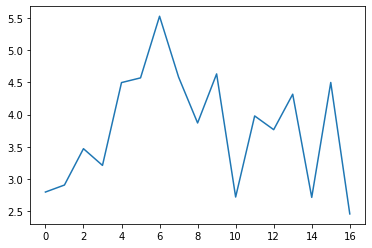

In [98]:
plt.plot(torch.sum(torch.mean(mha(A(y[0].unsqueeze(2))),dim=1),dim=-1).detach().numpy())

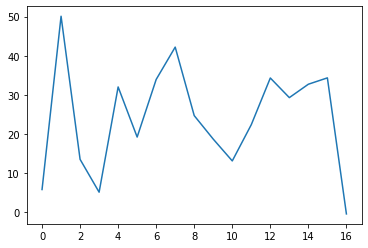

In [99]:
plt.plot(torch.sum(torch.mean((A(y[0].unsqueeze(2))),dim=1),dim=-1).detach().numpy())

In [70]:
plt.plot(torch.sum(torch.mean(A(y[0]),dim=1),dim=-1).detach().numpy())

RuntimeError: The size of tensor a (2) must match the size of tensor b (22) at non-singleton dimension 2

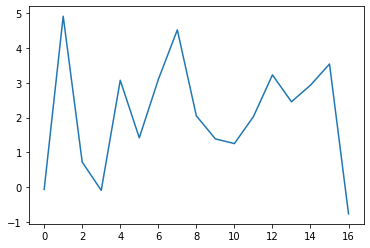

In [71]:
plt.plot(np.sum(y[0].detach().numpy(),axis=-1))

In [43]:
A=PositionalEncoding(2)
#print(y[0].shape,y[0])
print(y[0].unsqueeze(2).shape,y[0].unsqueeze(2))

torch.Size([17, 2, 1]) tensor([[[ 0.5127],
         [-0.5811]],

        [[ 3.3215],
         [ 1.5918]],

        [[ 0.8344],
         [-0.1156]],

        [[ 0.2717],
         [-0.3654]],

        [[ 1.5706],
         [ 1.5015]],

        [[ 1.6785],
         [-0.2621]],

        [[ 2.6895],
         [ 0.4036]],

        [[ 1.5773],
         [ 2.9435]],

        [[ 1.3532],
         [ 0.6959]],

        [[ 1.7631],
         [-0.3777]],

        [[ 0.7841],
         [ 0.4665]],

        [[ 1.6514],
         [ 0.3747]],

        [[ 1.5906],
         [ 1.6355]],

        [[ 2.1142],
         [ 0.3390]],

        [[ 1.3949],
         [ 1.5360]],

        [[ 1.8245],
         [ 1.7146]],

        [[ 0.8754],
         [-1.6474]]], grad_fn=<UnsqueezeBackward0>)


In [2097]:
m = SimpleMultiheadAttention(1,1)
m(input3)

ValueError: not enough values to unpack (expected 3, got 2)

In [1969]:
output.shape

torch.Size([22, 2, 22])

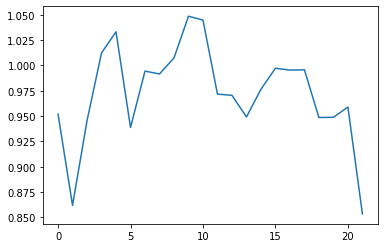

In [2096]:
plt.plot(list(torch.mean(torch.sum(output,dim=-1),dim=1)))

In [1958]:
#a=torch.sum(torch.mean(0.5*torch.sum(output,dim=-1),dim=1)) 
torch.sum((torch.mean(y[0],dim=-0)))

tensor(0.4782, grad_fn=<SumBackward0>)

In [2107]:
torch.mean(x, dim=-1)

tensor([[ 1.2550,  0.2358],
        [ 0.5305, -1.9337],
        [ 0.2608,  0.2125],
        [ 1.5066,  0.3028],
        [ 0.8320,  0.6239],
        [ 0.4364, -0.5442],
        [ 1.3770, -0.0377],
        [ 0.6687,  0.0242],
        [ 0.8975,  0.4175],
        [ 1.2909,  0.2514],
        [ 1.2989,  0.5744],
        [-0.0260,  0.0760],
        [ 1.4462,  0.3720],
        [ 0.1402,  0.1262],
        [ 0.5849,  0.2375],
        [ 0.6466,  0.3175],
        [ 0.4875,  0.0729],
        [ 0.6245,  0.5299],
        [ 0.4237,  0.2223],
        [ 0.8658,  0.1380],
        [ 1.2642,  0.1962],
        [-0.4285, -0.1579]], grad_fn=<MeanBackward1>)

In [1331]:
torch.matmul(torch.mean(y[0],dim=1),torch.mean(y[0],dim=1))

tensor(12.7563, grad_fn=<DotBackward0>)

In [2103]:
B = PositionalEncoding(1)(torch.tensor([[1,.2], [.2,.3], [.2,.3], [.2,.3]]))

#m=B(torch.sum(torch.mean(y[0],dim=1)).unsqueeze(2))
mha2= SimpleMultiheadAttention(2,1)
o = mha2(B)
torch.mean(torch.mean(o, dim=1))



tensor(-0.0471, grad_fn=<MeanBackward0>)

In [2072]:
mha2= SimpleMultiheadAttention(2,1)
z = PositionalEncoding(1)(input3)#(torch.tensor([[1,.2], [.2,.3], [.2,.3], [.2,.3]]))
sum(mha2(z))


tensor([[ 32.4650, -31.8607]], grad_fn=<AddBackward0>)

In [2094]:
input3

tensor([[ 0.9725, 42.7920]])

In [2093]:
torch.sum(mha2(z), dim=0)

tensor([[ 32.4650, -31.8607]], grad_fn=<SumBackward1>)

In [ ]:
z = PositionalEncoding(1)
z()

In [2002]:
np.sum([-0.8556,  1.7537])

0.8981

In [2014]:
print(torch.sum(o, dim=-1))
torch.sum(o, dim=-1)


tensor([[0.3260, 0.1453, 0.1656, 0.2158],
        [0.2598, 0.1821, 0.2203, 0.2543],
        [0.4327, 0.1485, 0.2074, 0.2569],
        [0.2326, 0.1530, 0.1680, 0.2241]], grad_fn=<SumBackward1>)


tensor([[0.3260, 0.1453, 0.1656, 0.2158],
        [0.2598, 0.1821, 0.2203, 0.2543],
        [0.4327, 0.1485, 0.2074, 0.2569],
        [0.2326, 0.1530, 0.1680, 0.2241]], grad_fn=<SumBackward1>)

In [2031]:
fs={}
feat = (torch.mean(torch.sum(output, dim=-1)), torch.sum(torch.sum(output, dim=-1)))
fs[sample] = feat



input3=torch.tensor([feat for feat in fs.values()])
input3


tensor([[ 0.9725, 42.7920]])

In [2025]:

PositionalEncoding(1)(feat)
#S#impleMultiheadAttention(2,1)(feat.unsqueeze(1))

#use mean and sum as input,to reduce each node reduced to 1 node, 2 dims
u = torch.tensor([[pred], [3.172]])
mha4= SimpleMultiheadAttention(2,1)#[1,1],[.2,.3])
g = PositionalEncoding(2)(u)
PositionalEncoding(torch.tensor([1,.2]),torch.tensor([.2,.3]))
n = mha4(g)
n



AttributeError: 'tuple' object has no attribute 'size'

In [1332]:
pred
label

11.4038

In [1123]:
B(torch.mean(y[0],dim=1))

tensor([[[-0.5386,  0.2746,  0.2121, -1.5067,  0.2118, -0.0281,  0.6355,
          -0.3063,  0.1980,  0.3358, -0.0419,  0.6330,  0.5565,  0.5108,
           0.0000, -0.4346, -0.5574, -0.0000, -0.6776,  0.2749,  0.0000]],

        [[ 0.3964,  1.2096,  1.1471, -0.5717,  1.1468,  0.9068,  1.5705,
           0.6287,  1.1330,  1.2707,  0.8931,  1.5679,  1.4915,  1.4458,
           1.0574,  0.5003,  0.0000,  0.3952,  0.2573,  1.2098,  0.0000]],

        [[ 0.4717,  0.0000,  1.2224, -0.4964,  0.0000,  0.9822,  1.6458,
           0.7040,  1.2083,  0.0000,  0.9685,  0.0000,  1.5669,  1.5212,
           1.1328,  0.5757,  0.4530,  0.4705,  0.3327,  1.2852,  1.1868]],

        [[-0.3818,  0.4314,  0.3689, -1.3499,  0.3686,  0.1287,  0.7923,
          -0.1495,  0.0000,  0.0000,  0.1149,  0.7898,  0.7133,  0.6676,
           0.2793, -0.0000, -0.4006, -0.3830, -0.5208,  0.4317,  0.3333]],

        [[-1.3795, -0.5663, -0.6288, -2.3476, -0.6291, -0.8690, -0.2054,
          -1.1472, -0.6429, -0.5051, -0

In [1064]:
torch.mean(y[0],dim=1)

tensor([-0.4847,  0.2472,  0.1909, -1.3560,  0.1906, -0.0253,  0.5719, -0.2757,
         0.1782,  0.3022, -0.0377,  0.5697,  0.5009,  0.4597,  0.1102, -0.3912,
        -0.5016, -0.4858, -0.6099,  0.2474,  0.1589], grad_fn=<MeanBackward1>)

In [890]:
np.log(3.4)

1.2237754316221157

In [885]:
np.log(np.abs(1 + 67))

4.219507705176107

In [853]:
y
label
torch.mean(y[0][17:])
label


11.4038

In [869]:
10.5 + .8 + 2.4 / 3

12.100000000000001

In [854]:
torch.max(torch.mean(output, dim=0))
y

tensor([[ 0.2337,  0.2968,  0.0480,  4.5044,  0.0468, 17.5079,  0.1077,  1.4653,
          0.2014,  6.6987,  0.3193,  1.8857,  0.1864,  9.5172,  8.6554,  1.1121,
          0.8656,  5.8812, 40.8738,  1.4486,  0.1704]], grad_fn=<PowBackward1>)

In [868]:
torch.mean(output, dim=-0)

tensor([[-1.9666, -2.7612, -1.1210, -6.5646, -3.7918, 10.5193, -2.6809, -3.7751,
         -0.1082, -2.6251, -2.9264, -5.2189,  0.4194, -2.8971,  0.8069, -2.7505,
         -1.6541, -0.9493, -3.4236, -1.0440,  2.4191, -0.6177]],
       grad_fn=<MeanBackward1>)

In [1467]:
torch.mean(y[0])

tensor(-0.1895, grad_fn=<MeanBackward0>)

In [1881]:
torch.sum(abs(output[0][0]))/3

#output

tensor(0.3748, grad_fn=<DivBackward0>)

In [1882]:
torch.sum(y[0])


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


tensor(-8.3372, grad_fn=<SumBackward0>)

In [761]:
torch.sum(output[6][0])

tensor(145.9846, grad_fn=<SumBackward0>)

In [1450]:
y[0]

tensor([[-0.2057, -1.3018],
        [ 0.2443, -0.2033],
        [ 0.4879,  0.0422],
        [-1.0623,  0.3138],
        [-1.1395,  0.4682],
        [-0.1005, -0.3962],
        [-0.2825, -0.4783],
        [-0.7066, -0.0881],
        [-0.1040, -0.3582],
        [ 0.1509,  0.0253],
        [-0.3069, -0.0187],
        [-0.1796, -0.3656],
        [ 0.2965,  0.3032],
        [ 0.0408,  0.0776],
        [ 0.6778, -0.0576],
        [-0.5937, -0.1995],
        [-0.0594, -0.3070],
        [-0.8209, -0.4834],
        [-0.8426, -0.5247],
        [ 0.1708, -0.1253],
        [ 0.1481, -0.2615],
        [-0.2241,  0.0129]], grad_fn=<SelectBackward0>)

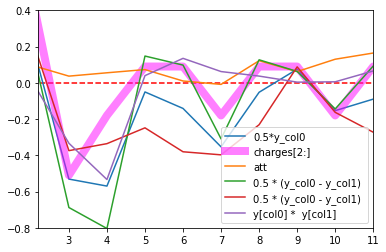

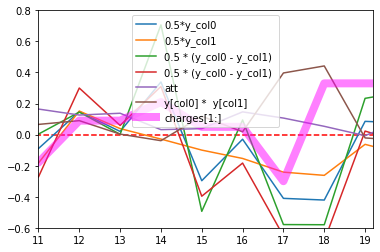

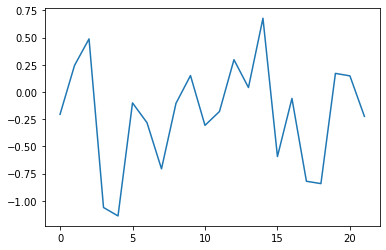

In [1722]:
plt.plot([a for a in list(range(0,22))],list(0.5*y[0][:,0]),label="0.5*y_col0")
#plt.plot([a for a in list(range(1,23))],list(0.5*y[0][:,1]),label="0.5*y_col1")
plt.plot()
[a for a in list(range(0,19))] + list([19])
#plt.plot(list(y[0][:,1])[1:],label="1")
#plt.plot(list(y[0][:,0] + (y[0][:,1])), label="y[col0] + y[col1]")
plt.plot(charges[2:], color="magenta", label="charges[2:]", linewidth=8, alpha=0.5)
plt.plot(att, label="att")
plt.plot(list(.5*(y[0][:,0]) - 0.5*(y[0][:,1])), label="0.5 * (y_col0 - y_col1) ")
plt.plot(list(.5*(y[0][:,0]) + 0.5*(y[0][:,1])), label="0.5 * (y_col0 - y_col1) ")
plt.plot(list((y[0][:,0] * (y[0][:,1]))), label="y[col0] *  y[col1]")
#plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")
#[a for a in list(range(0,22))]
plt.xlim(2.2, 11)
plt.ylim(-.8,.4)
plt.hlines([0], 1.2, 22, color="red", linestyles="--")
plt.legend()

plt.show()

plt.plot([a for a in list(range(0,22))],list(0.5*y[0][:,0]),label="0.5*y_col0")
plt.plot([a for a in list(range(0,22))],list(0.5*y[0][:,1]),label="0.5*y_col1")
#plt.plot(charges[1:], color="black", label="charges[1:]")
plt.plot(list((y[0][:,0] - 0.5*(y[0][:,1]))), label="0.5 * (y_col0 - y_col1) ")
plt.plot(list(.5*(y[0][:,0]) + 0.5*(y[0][:,1])), label="0.5 * (y_col0 - y_col1) ")
plt.plot(att, label="att")
plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")
plt.plot(charges[1:], color="magenta", label="charges[1:]", linewidth=8, alpha=0.5)
#plt.plot(list((y[0][:,0] * (y[0][:,1]))), label="y[col0] *  y[col1]")
#plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")
#[a for a in list(range(0,22))]
plt.xlim(11, 19.2)
plt.ylim(-.6,.8)
plt.hlines([0], 1.2, 22, color="red", linestyles="--")
plt.legend()


#plt.plot(list(y[0][:,1]))
#plt.plot(list(att))

plt.show()

plt.plot(list(y[0][:,0]), label="y[col0] +  y[col1]")
#plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")

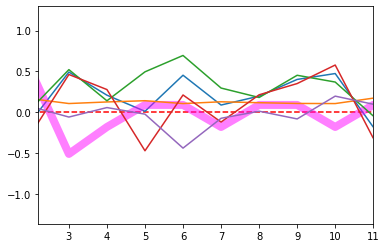

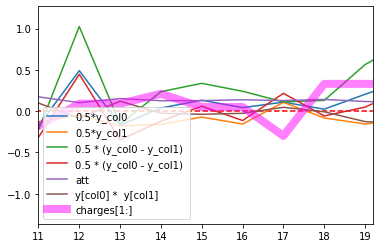

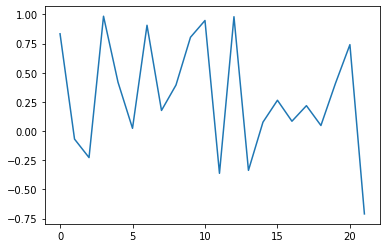

In [1967]:
#ummmm 3am lassst night change mod
plt.plot([a for a in list(range(0,22))],list(0.5*y[0][:,0]),label="0.5*y_col0")
#plt.plot([a for a in list(range(1,23))],list(0.5*y[0][:,1]),label="0.5*y_col1")
plt.plot()
[a for a in list(range(0,19))] + list([19])
#plt.plot(list(y[0][:,1])[1:],label="1")
#plt.plot(list(y[0][:,0] + (y[0][:,1])), label="y[col0] + y[col1]")
plt.plot(charges[2:], color="magenta", label="charges[2:]", linewidth=8, alpha=0.5)
plt.plot(att, label="att")
plt.plot(list(.5*(y[0][:,0]) - 0.5*(y[0][:,1])), label="0.5 * (y_col0 - y_col1) ")
plt.plot(list(.5*(y[0][:,0]) + 0.5*(y[0][:,1])), label="0.5 * (y_col0 - y_col1) ")
plt.plot(list((y[0][:,0] * (y[0][:,1]))), label="y[col0] *  y[col1]")
#plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")
#[a for a in list(range(0,22))]
plt.xlim(2.2, 11)
#plt.ylim(-.8,.4)
plt.hlines([0], 1.2, 22, color="red", linestyles="--")
#plt.legend()

plt.show()

plt.plot([a for a in list(range(0,22))],list(0.5*y[0][:,0]),label="0.5*y_col0")
plt.plot([a for a in list(range(0,22))],list(0.5*y[0][:,1]),label="0.5*y_col1")
#plt.plot(charges[1:], color="black", label="charges[1:]")
plt.plot(list((y[0][:,0] - 0.5*(y[0][:,1]))), label="0.5 * (y_col0 - y_col1) ")
plt.plot(list(.5*(y[0][:,0]) + 0.5*(y[0][:,1])), label="0.5 * (y_col0 - y_col1) ")
plt.plot(att, label="att")
plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")
plt.plot(charges[1:], color="magenta", label="charges[1:]", linewidth=8, alpha=0.5)
#plt.plot(list((y[0][:,0] * (y[0][:,1]))), label="y[col0] *  y[col1]")
#plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")
#[a for a in list(range(0,22))]
plt.xlim(11, 19.2)
#plt.ylim(-.6,.8)
plt.hlines([0], 1.2, 22, color="red", linestyles="--")
plt.legend()


#plt.plot(list(y[0][:,1]))
#plt.plot(list(att))

plt.show()

plt.plot(list(y[0][:,0]), label="y[col0] +  y[col1]")
#plt.plot(list(y[0][:,0] * (y[0][:,1])), label="y[col0] *  y[col1]")


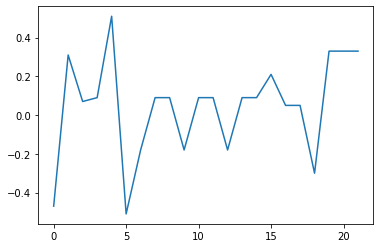

In [1726]:
plt.plot(charges)

ValueError: only one element tensors can be converted to Python scalars

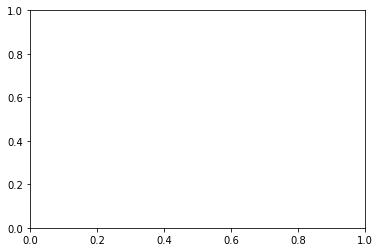

In [1792]:
#plt.plot(list(output[0][0]))
#plt.plot(list(output[0][0] * output[0][1]))
#plt.plot(list(torch.log(10**(output[0][0]+torch.ones(len(output[0][0])) + output[0][1]+torch.ones(len(output[0][0]))))))

#plt.plot((list(7+torch.log(10**torch.exp(2*(output[0][0] + output[0][1]))))))

pred
max(list(7+torch.log(10**torch.exp(2*(output[0][0] * output[0][1])))))
plt.plot(list(torch.sum(output, dim=1)))

ValueError: only one element tensors can be converted to Python scalars

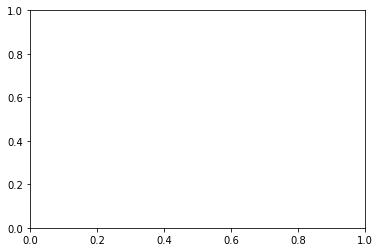

In [1827]:
plt.plot(list(torch.sum(output, dim=1)))

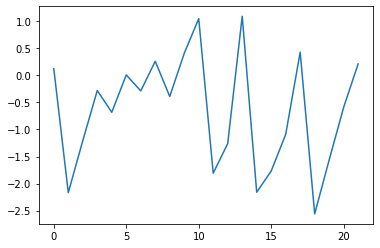

In [1847]:
plt.plot(list(torch.mean(torch.sum(output, dim=0),dim=-2)))

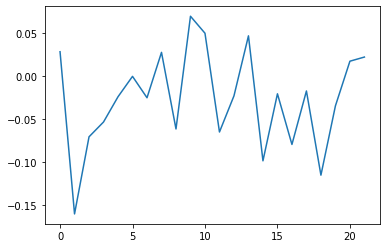

In [1822]:
plt.plot(list(output[21][1]))

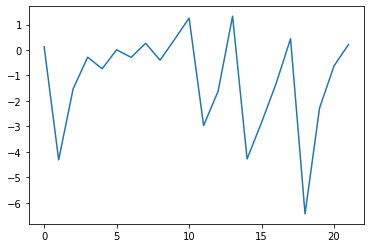

In [1852]:
plt.plot(list(torch.sinh((torch.mean(torch.sum(output, dim=0),dim=-2)))))

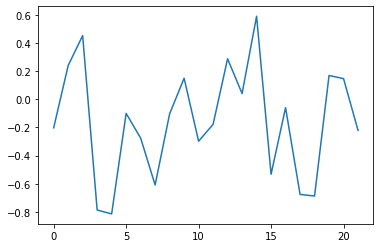

In [1862]:
plt.plot(list(torch.tanh((y[0][:,0]))))

In [1873]:
torch.mean(-sum(y[0])) + 7
label
#torch.mean(-sum(y[0])) + 7

11.3289

In [1860]:
torch.mean(1/torch.sinh((y[0][:,0])))

tensor(-0.4550, grad_fn=<MeanBackward0>)

In [1504]:
len(charges)

22

In [1490]:
output

[0.11495932191610336,
 -0.004088055808097124,
 0.09878379106521606,
 0.037010230123996735,
 0.055487051606178284,
 0.0731925517320633,
 0.010208954103291035,
 -0.00858079269528389,
 0.1221369206905365,
 0.06208626180887222,
 0.13033859431743622,
 0.16456152498722076,
 0.12599699199199677,
 0.13748842477798462,
 0.03192657232284546,
 0.03845188021659851,
 0.14637255668640137,
 0.10654786229133606,
 0.05342473089694977,
 -0.006955844350159168,
 0.10574427992105484]

In [1471]:
charges = [partial_charges[atom] for atom in atoms_order]

NameError: name 'atoms_order' is not defined

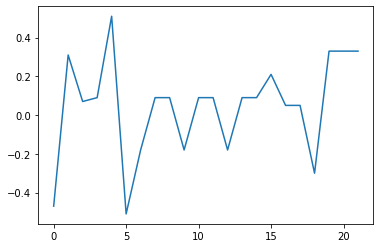

In [1473]:
# Partial charges from AMBER RTF files
partial_charges = {
    "N": -0.47, "HN": 0.31, "CA": 0.07, "HA": 0.09, "C": 0.51, "O": -0.51,
    "CB": -0.18, "HB2": 0.09, "HB3": 0.09, "CG": -0.18, "HG2": 0.09, "HG3": 0.09,
    "CD": -0.18, "HD2": 0.09, "HD3": 0.09, "CE": 0.21, "HE2": 0.05, "HE3": 0.05,
    "NZ": -0.30, "HZ1": 0.33, "HZ2": 0.33, "HZ3": 0.33
}

# Atom names in the given order
atoms_order = [
    "N", "HN", "CA", "HA", "C", "O", "CB", "HB2", "HB3", "CG", "HG2", "HG3",
    "CD", "HD2", "HD3", "CE", "HE2", "HE3", "NZ", "HZ1", "HZ2", "HZ3"
]

charges = [partial_charges[atom] for atom in atoms_order]

plt.plot(charges)

todo: decide max seq length!

In [1470]:
y[0][:,0] * y[0][:,1]
#sum((y[0][:,0] * y[0][:,1])[-3::])

tensor([ 0.2677, -0.0497,  0.0206, -0.3333, -0.5335,  0.0398,  0.1351,  0.0623,
         0.0373,  0.0038,  0.0057,  0.0657,  0.0899,  0.0032, -0.0390,  0.1184,
         0.0183,  0.3968,  0.4421, -0.0214, -0.0387, -0.0029],
       grad_fn=<MulBackward0>)

In [1491]:
sample
#all_data
pdb
y[0]


tensor([[-0.2057, -1.3018],
        [ 0.2443, -0.2033],
        [ 0.4879,  0.0422],
        [-1.0623,  0.3138],
        [-1.1395,  0.4682],
        [-0.1005, -0.3962],
        [-0.2825, -0.4783],
        [-0.7066, -0.0881],
        [-0.1040, -0.3582],
        [ 0.1509,  0.0253],
        [-0.3069, -0.0187],
        [-0.1796, -0.3656],
        [ 0.2965,  0.3032],
        [ 0.0408,  0.0776],
        [ 0.6778, -0.0576],
        [-0.5937, -0.1995],
        [-0.0594, -0.3070],
        [-0.8209, -0.4834],
        [-0.8426, -0.5247],
        [ 0.1708, -0.1253],
        [ 0.1481, -0.2615],
        [-0.2241,  0.0129]], grad_fn=<SelectBackward0>)

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


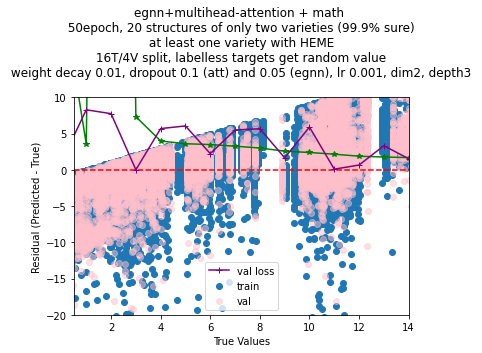

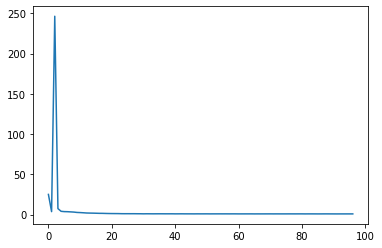

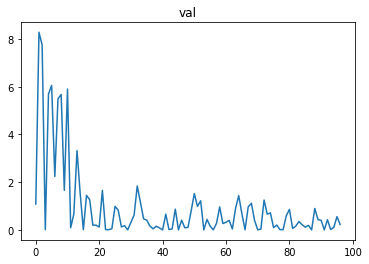

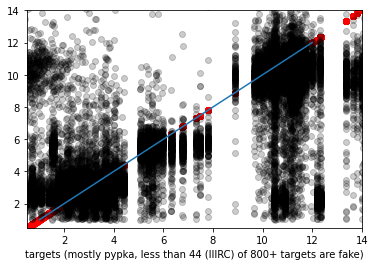

In [1437]:
residuals,vresiduals, ts,ps, es =[],[],[],[],[]
vresiduals, vts,vps, ves =[],[],[],[]
for i in range(97):
    r = results[i]
    #print(r)
    
    e=[]
    for re in r:
        residuals.append(re[3] - re[2])
        ts.append(re[3])
        #ps.append(re[2])
        e.append(re[4])

    es.append(np.mean(e))

    V=vresults[i]
    e=[]
    #print(v)

    for v in V:
        vresiduals.append(v[3] - v[2])
        vts.append(v[3])
        vps.append(v[2])
        e.append(re[4])

    ves.append(np.mean(e))




plt.scatter(ts, residuals, alpha=1, label="train")
#plt.ylim(-20,20)
plt.axhline(y=0, color='r', linestyle='--')



plt.xlabel("True Values")
plt.ylabel("Residual (Predicted - True)")
#plt.title("5e, dim 2,depth 3, 2 nn, lr=.0001 wd=1, 50 tokens, dropout .6 \n dne = 13")
plt.title("egnn+multihead-attention + math \n 50epoch, 20 structures of only two varieties (99.9% sure) \n at least one variety with HEME \n 16T/4V split, labelless targets get random value \n weight decay 0.01, dropout 0.1 (att) and 0.05 (egnn), lr 0.001, dim2, depth3 \n")
plt.plot(es, color="g", marker="*")
plt.plot(ves, color="purple", marker="+", label="val loss")
plt.scatter(vts, vresiduals, alpha=0.5, color="pink", label="val")
plt.xlim(.5,14)
plt.ylim(-20,10)
plt.legend()
plt.show()

plt.plot(es)
plt.show()
plt.plot(ves)
plt.title(label="val")
#plt.title("errors for preceding graph \n")
plt.show()

plt.scatter(vts, vts, color="red", alpha=0.5)
#plt.scatter(vps, vps, color="red", alpha=0.2)
plt.scatter(vts, vps, color="black", alpha=0.2)
plt.plot(range(1,13),range(1,13))
plt.xlim(.5,14)
plt.ylim(.5,14)
plt.xlabel("targets (mostly pypka, less than 44 (IIIRC) of 800+ targets are fake)")
plt.show()
#plt.title("lr 0.01 400 epochs dim2 depth 3 from 2 to end bc immediatelz went down")


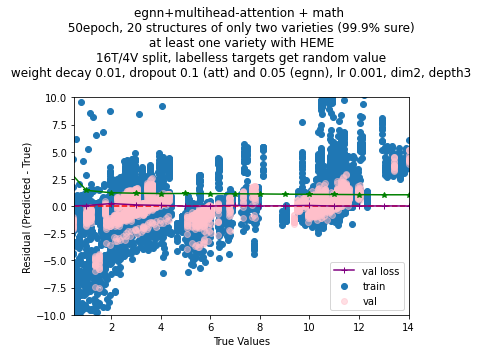

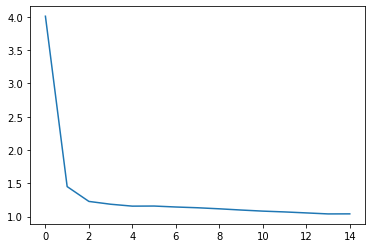

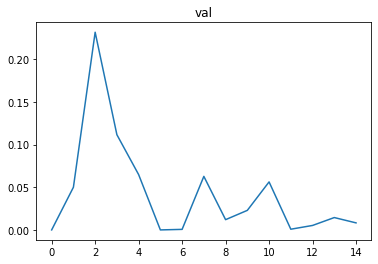

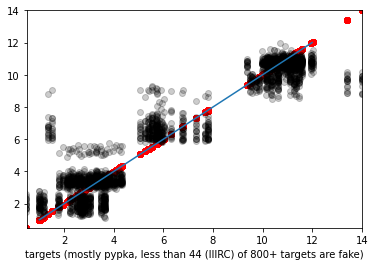

In [1896]:
residuals,vresiduals, ts,ps, es =[],[],[],[],[]
vresiduals, vts,vps, ves =[],[],[],[]
for i in range(nepochs):
    r = results[i]
    #print(r)
    
    e=[]
    for re in r:
        residuals.append(re[3] - re[2])
        ts.append(re[3])
        #ps.append(re[2])
        e.append(re[4])

    es.append(np.mean(e))

    V=vresults[i]
    e=[]
    #print(v)

    for v in V:
        vresiduals.append(v[3] - v[2])
        vts.append(v[3])
        vps.append(v[2])
        e.append(re[4])

    ves.append(np.mean(e))




plt.scatter(ts, residuals, alpha=1, label="train")
#plt.ylim(-20,20)
plt.axhline(y=0, color='r', linestyle='--')



plt.xlabel("True Values")
plt.ylabel("Residual (Predicted - True)")
#plt.title("5e, dim 2,depth 3, 2 nn, lr=.0001 wd=1, 50 tokens, dropout .6 \n dne = 13")
plt.title("egnn+multihead-attention + math \n 50epoch, 20 structures of only two varieties (99.9% sure) \n at least one variety with HEME \n 16T/4V split, labelless targets get random value \n weight decay 0.01, dropout 0.1 (att) and 0.05 (egnn), lr 0.001, dim2, depth3 \n")
plt.plot(es, color="g", marker="*")
plt.plot(ves, color="purple", marker="+", label="val loss")
plt.scatter(vts, vresiduals, alpha=0.5, color="pink", label="val")
plt.xlim(.5,14)
plt.ylim(-10,10)
plt.legend()
plt.show()

plt.plot(es)
plt.show()
plt.plot(ves)
plt.title(label="val")
#plt.title("errors for preceding graph \n")
plt.show()

plt.scatter(vts, vts, color="red", alpha=0.5)
#plt.scatter(vps, vps, color="red", alpha=0.2)
plt.scatter(vts, vps, color="black", alpha=0.2)
plt.plot(range(1,13),range(1,13))
plt.xlim(.5,14)
plt.ylim(.5,14)
plt.xlabel("targets (mostly pypka, less than 44 (IIIRC) of 800+ targets are fake)")
plt.show()
#plt.title("lr 0.01 400 epochs dim2 depth 3 from 2 to end bc immediatelz went down")

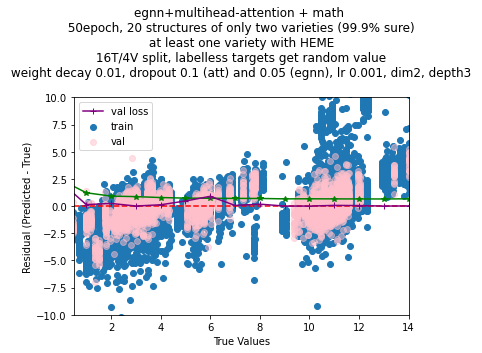

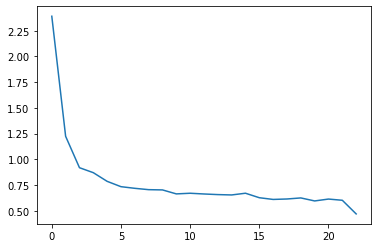

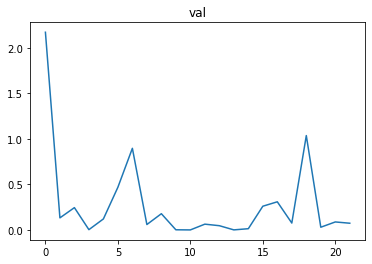

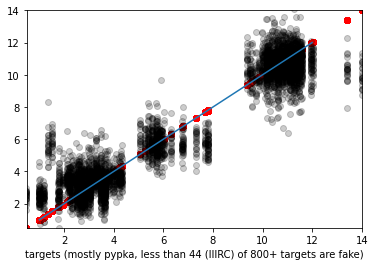

In [1921]:
residuals,vresiduals, ts,ps, es =[],[],[],[],[]
vresiduals, vts,vps, ves =[],[],[],[]
for i in range(23):
    r = results[i]
    #print(r)
    
    e=[]
    for re in r:
        residuals.append(re[3] - re[2])
        ts.append(re[3])
        #ps.append(re[2])
        e.append(re[4])

    es.append(np.mean(e))

    V=vresults[i]
    e=[]
    #print(v)

    for v in V:
        vresiduals.append(v[3] - v[2])
        vts.append(v[3])
        vps.append(v[2])
        e.append(re[4])

    ves.append(np.mean(e))




plt.scatter(ts, residuals, alpha=1, label="train")
#plt.ylim(-20,20)
plt.axhline(y=0, color='r', linestyle='--')



plt.xlabel("True Values")
plt.ylabel("Residual (Predicted - True)")
#plt.title("5e, dim 2,depth 3, 2 nn, lr=.0001 wd=1, 50 tokens, dropout .6 \n dne = 13")
plt.title("egnn+multihead-attention + math \n 50epoch, 20 structures of only two varieties (99.9% sure) \n at least one variety with HEME \n 16T/4V split, labelless targets get random value \n weight decay 0.01, dropout 0.1 (att) and 0.05 (egnn), lr 0.001, dim2, depth3 \n")
plt.plot(es, color="g", marker="*")
plt.plot(ves, color="purple", marker="+", label="val loss")
plt.scatter(vts, vresiduals, alpha=0.5, color="pink", label="val")
plt.xlim(.5,14)
plt.ylim(-10,10)
plt.legend()
plt.show()

plt.plot(es)
plt.show()
plt.plot(ves)
plt.title(label="val")
#plt.title("errors for preceding graph \n")
plt.show()

plt.scatter(vts, vts, color="red", alpha=0.5)
#plt.scatter(vps, vps, color="red", alpha=0.2)
plt.scatter(vts, vps, color="black", alpha=0.2)
plt.plot(range(1,13),range(1,13))
plt.xlim(.5,14)
plt.ylim(.5,14)
plt.xlabel("targets (mostly pypka, less than 44 (IIIRC) of 800+ targets are fake)")
plt.show()
#plt.title("lr 0.01 400 epochs dim2 depth 3 from 2 to end bc immediatelz went down")

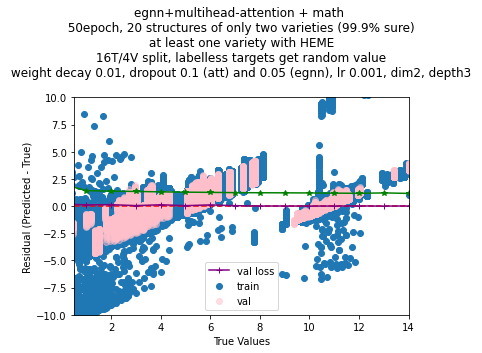

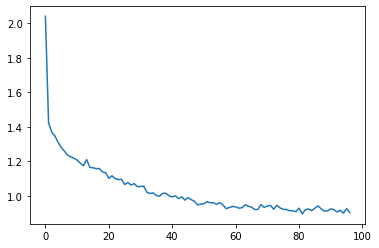

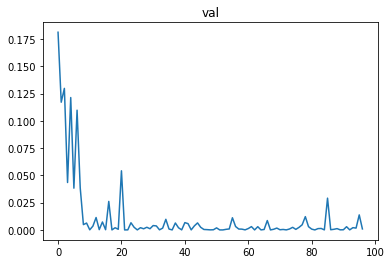

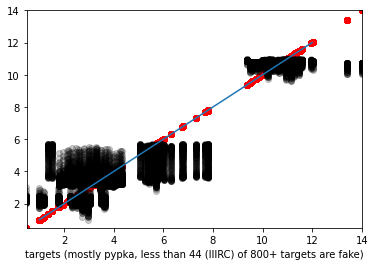

In [1901]:
residuals,vresiduals, ts,ps, es =[],[],[],[],[]
vresiduals, vts,vps, ves =[],[],[],[]
for i in range(nepochs):
    r = results[i]
    #print(r)
    
    e=[]
    for re in r:
        residuals.append(re[3] - re[2])
        ts.append(re[3])
        #ps.append(re[2])
        e.append(re[4])

    es.append(np.mean(e))

    V=vresults[i]
    e=[]
    #print(v)

    for v in V:
        vresiduals.append(v[3] - v[2])
        vts.append(v[3])
        vps.append(v[2])
        e.append(re[4])

    ves.append(np.mean(e))




plt.scatter(ts, residuals, alpha=1, label="train")
#plt.ylim(-20,20)
plt.axhline(y=0, color='r', linestyle='--')



plt.xlabel("True Values")
plt.ylabel("Residual (Predicted - True)")
#plt.title("5e, dim 2,depth 3, 2 nn, lr=.0001 wd=1, 50 tokens, dropout .6 \n dne = 13")
plt.title("egnn+multihead-attention + math \n 50epoch, 20 structures of only two varieties (99.9% sure) \n at least one variety with HEME \n 16T/4V split, labelless targets get random value \n weight decay 0.01, dropout 0.1 (att) and 0.05 (egnn), lr 0.001, dim2, depth3 \n")
plt.plot(es, color="g", marker="*")
plt.plot(ves, color="purple", marker="+", label="val loss")
plt.scatter(vts, vresiduals, alpha=0.5, color="pink", label="val")
plt.xlim(.5,14)
plt.ylim(-10,10)
plt.legend()
plt.show()

plt.plot(es)
plt.show()
plt.plot(ves)
plt.title(label="val")
#plt.title("errors for preceding graph \n")
plt.show()

plt.scatter(vts, vts, color="red", alpha=0.5)
#plt.scatter(vps, vps, color="red", alpha=0.2)
plt.scatter(vts, vps, color="black", alpha=0.2)
plt.plot(range(1,13),range(1,13))
plt.xlim(.5,14)
plt.ylim(.5,14)
plt.xlabel("targets (mostly pypka, less than 44 (IIIRC) of 800+ targets are fake)")
plt.show()
#plt.title("lr 0.01 400 epochs dim2 depth 3 from 2 to end bc immediatelz went down")

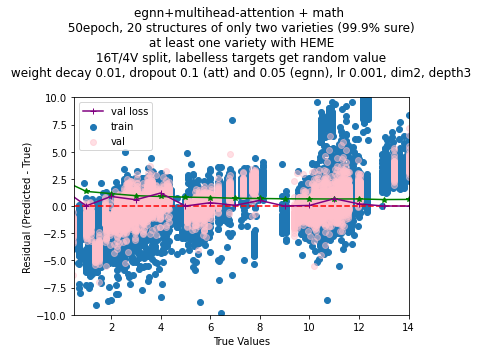

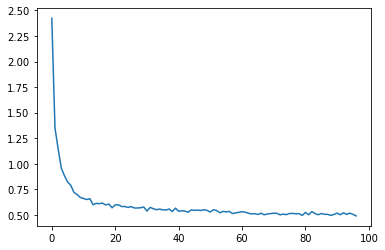

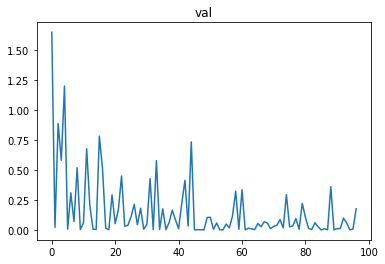

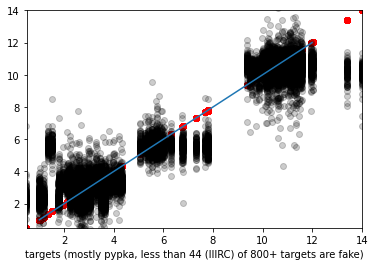

In [1961]:

residuals,vresiduals, ts,ps, es =[],[],[],[],[]
vresiduals, vts,vps, ves =[],[],[],[]
for i in range(nepochs):
    r = results[i]
    #print(r)
    
    e=[]
    for re in r:
        residuals.append(re[3] - re[2])
        ts.append(re[3])
        #ps.append(re[2])
        e.append(re[4])

    es.append(np.mean(e))

    V=vresults[i]
    e=[]
    #print(v)

    for v in V:
        vresiduals.append(v[3] - v[2])
        vts.append(v[3])
        vps.append(v[2])
        e.append(re[4])

    ves.append(np.mean(e))




plt.scatter(ts, residuals, alpha=1, label="train")
#plt.ylim(-20,20)
plt.axhline(y=0, color='r', linestyle='--')



plt.xlabel("True Values")
plt.ylabel("Residual (Predicted - True)")
#plt.title("5e, dim 2,depth 3, 2 nn, lr=.0001 wd=1, 50 tokens, dropout .6 \n dne = 13")
plt.title("egnn+multihead-attention + math \n 50epoch, 20 structures of only two varieties (99.9% sure) \n at least one variety with HEME \n 16T/4V split, labelless targets get random value \n weight decay 0.01, dropout 0.1 (att) and 0.05 (egnn), lr 0.001, dim2, depth3 \n")
plt.plot(es, color="g", marker="*")
plt.plot(ves, color="purple", marker="+", label="val loss")
plt.scatter(vts, vresiduals, alpha=0.5, color="pink", label="val")
plt.xlim(.5,14)
plt.ylim(-10,10)
plt.legend()
plt.show()

plt.plot(es)
plt.show()
plt.plot(ves)
plt.title(label="val")
#plt.title("errors for preceding graph \n")
plt.show()

plt.scatter(vts, vts, color="red", alpha=0.5)
#plt.scatter(vps, vps, color="red", alpha=0.2)
plt.scatter(vts, vps, color="black", alpha=0.2)
plt.plot(range(1,13),range(1,13))
plt.xlim(.5,14)
plt.ylim(.5,14)
plt.xlabel("targets (mostly pypka, less than 44 (IIIRC) of 800+ targets are fake)")
plt.show()
#plt.title("lr 0.01 400 epochs dim2 depth 3 from 2 to end bc immediatelz went down")

In [1952]:
sum(torch.mean(y[0],dim=-2)) #partial chrge?? prot??
sum(torch.mean(y[0],dim=-1))



tensor(2.5516, grad_fn=<AddBackward0>)

In [1438]:
ves

[1.0876,
 8.283990000000001,
 7.75109,
 0.012349999999999998,
 5.695049999999999,
 6.05503,
 2.23818,
 5.495040000000002,
 5.673189999999999,
 1.6588699999999998,
 5.90524,
 0.09207,
 0.6636299999999999,
 3.3251899999999996,
 1.5324899999999995,
 0.00895,
 1.4489599999999998,
 1.2673999999999999,
 0.19836,
 0.19997000000000004,
 0.11984999999999998,
 1.65643,
 0.01572,
 0.009300000000000001,
 0.05206999999999999,
 0.99046,
 0.8245099999999999,
 0.12768,
 0.17686,
 0.0019599999999999995,
 0.32060999999999995,
 0.61429,
 1.8419200000000004,
 1.16215,
 0.46595,
 0.40848,
 0.16178999999999996,
 0.04569,
 0.15423999999999996,
 0.08586000000000003,
 0.0025499999999999997,
 0.6607399999999999,
 0.01683,
 0.04303,
 0.8709100000000002,
 0.0030900000000000003,
 0.40767999999999993,
 0.09109999999999997,
 0.10473,
 0.79231,
 1.5249000000000001,
 0.9864599999999998,
 1.22123,
 0.004220000000000001,
 0.44089999999999996,
 0.15543,
 0.00383,
 0.27776,
 0.9625299999999999,
 0.2701700000000001,
 0.319

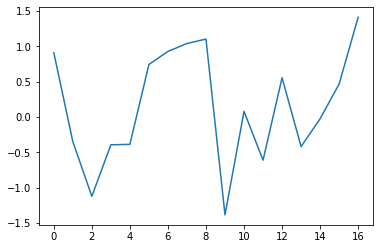

In [1934]:
#pred = sum(torch.sum(output[0],dim=-2))
plt.plot(list(torch.mean(y[0],dim=1)))
#plt.plot(list(torch.sum(output[0],dim=-2)))
#pred
#sample
#updATE 

In [1412]:
torch.sum(torch.abs((torch.mean(y[0],dim=1))))
#torch.min(torch.mean(y[0],dim=1))


tensor(5.4597, grad_fn=<SumBackward0>)

In [1413]:
sum(sum(y))

tensor([-4.7768,  0.4321], grad_fn=<AddBackward0>)

label
att

In [1414]:
output

tensor([[[ 1.1496e-01,  1.0391e-01,  1.1783e-01,  1.6433e-01, -1.6158e-01,
           8.9522e-02, -8.1926e-02,  2.2535e-03, -1.8889e-01,  1.5831e-02,
          -1.4571e-01, -2.7045e-01, -1.8320e-01,  1.4009e-01, -1.4963e-01,
          -7.6368e-02, -6.1635e-02,  2.0117e-02,  7.4543e-03, -1.1037e-01,
          -8.6615e-04, -1.1765e-01],
         [ 8.0207e-02,  9.7228e-02,  1.8719e-01,  2.2441e-01, -2.2072e-01,
           1.0151e-01, -5.9836e-02, -1.6999e-02, -1.7114e-01,  7.9111e-02,
          -1.5173e-01, -3.6523e-01, -2.6459e-01,  1.1497e-01, -2.0310e-01,
          -4.4643e-02, -7.9572e-02, -1.1103e-02, -1.5391e-02, -1.3758e-01,
          -5.4938e-03, -1.7942e-01]],

        [[-4.0881e-03,  5.8974e-02,  1.1613e-01,  2.6422e-01, -6.6653e-02,
           8.9053e-02, -2.6279e-02,  1.4548e-01, -8.4164e-02, -1.2148e-01,
          -1.2242e-01, -3.0125e-01, -1.5687e-01,  9.7183e-02, -1.7681e-01,
           1.7768e-02, -4.6786e-02,  5.9820e-02, -3.7417e-02, -4.6691e-02,
          -1.2793e-01, -

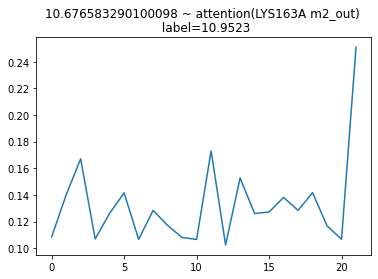

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


tensor(0.0482)

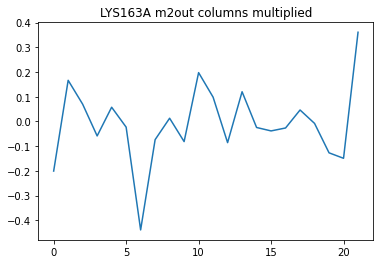

In [1962]:
output[0].detach().numpy()
att = [o[0][0].item() for o in output]
plt.plot(att)
plt.title(f"{pred} ~ attention({sample} m2_out) \n label={label}")
sum(att)
#np.sum(att)
plt.show()
#plt.plot(list(y[0][:,0]))
#plt.plot(list(y[0][:,1]))
plt.plot(list(y[0][:,0] * y[0][:,1]))
plt.title(f"{sample} m2out columns multiplied")

#plt.plot(list(torch.mean(y,dim=0)))
torch.matmul(torch.tensor(y[0][:,0] * y[0][:,1]),torch.tensor(att))
torch.matmul(torch.tensor(y[0][:,0] * y[0][:,1]),torch.tensor(att))

In [1434]:
torch.mean(10 ** y[0])


tensor(1.4091, grad_fn=<MeanBackward0>)

In [988]:
import torch
import torch.nn as nn

class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        # In self-attention, query, key, and value are all the same.
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs#, attn_weights

# Example usage:


# Create a random tensor in the expected shape: (seq_length, batch_size, embed_dim)
z = torch.randn(22, 1, 2) #nnodes, 1, dim

#figure out attention scores for ea<
# ch part of the input and then combine them.
#so can multiply together amino acids of entire protein, or e.g. the dimensions
#used as output.
print(y[0].shape)
x=y[0].unsqueeze(2)
print(x.shape)
#print(z)

#mha = SimpleMultiheadAttention(22, 1)
output= mha(PositionalEncoding(22)(x))
print("Multihead Attention Output Shape:", output.shape)   # (5, 2, 16)
print("Multihead Attention Weights Shape:", weights.shape)   # (2*num_heads, 5, 5)
print(weights)
#torch.log(torch.abs(sum(
a = torch.sum(output[0],dim=-2)
print(len(torch.sum(output[0],dim=0)))
torch.log(7+(torch.abs(torch.sum(torch.sum(output[0],dim=-2)))))



torch.Size([15, 2])
torch.Size([15, 2, 1])
Multihead Attention Output Shape: torch.Size([15, 2, 22])
Multihead Attention Weights Shape: torch.Size([1, 15, 15])
tensor([[[1.3033e-07, 2.3046e-07, 1.5368e-07, 1.5950e-06, 2.0091e-07,
          1.7502e-06, 2.6333e-06, 3.1753e-07, 9.9999e-01, 7.1756e-07,
          2.0194e-07, 1.8953e-07, 2.6484e-07, 3.7125e-07, 1.2543e-07],
         [1.1914e-28, 2.1591e-28, 1.2770e-28, 2.3214e-26, 2.4838e-28,
          2.1664e-27, 2.9677e-27, 3.9180e-28, 1.0000e+00, 2.5882e-27,
          1.3767e-28, 1.5582e-28, 2.7771e-28, 5.0405e-28, 5.2851e-29],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+0

tensor(2.5937, grad_fn=<LogBackward0>)

In [951]:
label

3.09459

x

In [678]:
x

tensor([[[4.6209e-02]],

        [[8.8309e-01]],

        [[2.7101e+00]],

        [[7.5548e+00]],

        [[1.0840e+00]],

        [[1.0394e+01]],

        [[7.3651e+00]],

        [[2.4021e+00]],

        [[6.5257e+01]],

        [[3.4737e+00]],

        [[6.4224e-01]],

        [[8.1744e-01]],

        [[1.2052e+00]],

        [[3.3179e+00]],

        [[3.2686e-01]]], grad_fn=<UnsqueezeBackward0>)

In [679]:
output

tensor([[[ -4.1536, -31.3089, -16.4627, -11.2560,  -8.4730,  32.0738, -19.2003,
           -1.1521,   4.9170, -37.4337,  10.4717,  41.0693,  18.8291,  -8.0370,
           46.4629, -29.1576,   5.8320,  51.1178, -39.4162,  36.3856,  -6.4433,
           14.3187]],

        [[ -4.1537, -31.3092, -16.4628, -11.2560,  -8.4731,  32.0741, -19.2005,
           -1.1520,   4.9171, -37.4340,  10.4718,  41.0696,  18.8293,  -8.0371,
           46.4633, -29.1579,   5.8320,  51.1182, -39.4165,  36.3859,  -6.4433,
           14.3188]],

        [[ -4.1537, -31.3092, -16.4628, -11.2560,  -8.4731,  32.0741, -19.2005,
           -1.1520,   4.9171, -37.4340,  10.4718,  41.0696,  18.8293,  -8.0371,
           46.4633, -29.1579,   5.8320,  51.1182, -39.4165,  36.3859,  -6.4433,
           14.3188]],

        [[ -4.1537, -31.3092, -16.4628, -11.2560,  -8.4731,  32.0741, -19.2005,
           -1.1520,   4.9171, -37.4340,  10.4718,  41.0696,  18.8293,  -8.0371,
           46.4633, -29.1579,   5.8320,  51.1182, -

In [667]:
PositionalEncoding(22)(x)

tensor([[[24.5451, 25.6562, 24.5451, 25.6562, 24.5451, 25.6562, 24.5451,
          25.6562, 24.5451, 25.6562, 24.5451, 25.6562, 24.5451, 25.6562,
          24.5451, 25.6562, 24.5451,  0.0000, 24.5451, 25.6562, 24.5451,
          25.6562]],

        [[ 0.0000,  7.4765,  7.3422,  7.8848,  7.0831,  7.9678,  0.0000,
           7.9836,  6.9151,  7.9866,  6.8930,  7.9871,  6.8834,  7.9872,
           6.8793,  7.9872,  6.8775,  7.9872,  6.8767,  7.9872,  6.8764,
           7.9872]],

        [[ 7.9487,  6.4760,  7.7846,  7.6585,  7.3451,  7.9724,  7.1178,
           8.0349,  7.0163,  8.0468,  6.9721,  8.0490,  6.9530,  8.0494,
           6.9447,  8.0495,  6.9411,  8.0495,  6.9396,  8.0495,  6.9389,
           8.0495]],

        [[ 6.1104,  4.8536,  7.0238,  6.2523,  6.5458,  6.8937,  6.2213,
           7.0320,  6.0704,  7.0585,  6.0042,  7.0635,  5.9755,  7.0645,
           5.9631,  7.0646,  5.9577,  7.0647,  5.9554,  0.0000,  5.9543,
           7.0647]],

        [[19.7158, 19.8304, 21.6535,

In [657]:
att

[8.521376609802246,
 8.616423606872559,
 3.596177101135254,
 8.692103385925293,
 8.690157890319824,
 8.692734718322754,
 8.692829132080078,
 8.692830085754395,
 5.876502990722656,
 8.692819595336914,
 8.692826271057129,
 7.386716365814209,
 8.692830085754395,
 8.692830085754395,
 8.683379173278809,
 8.69206714630127,
 8.692830085754395,
 8.692830085754395,
 8.692819595336914,
 8.692830085754395,
 8.517755508422852,
 8.664810180664062]

In [1011]:
y[0].shape

b=PositionalEncoding(54)
b(y[0].unsqueeze)


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 54)

In [120]:
#old_model = pnet #this one trained on bad labels

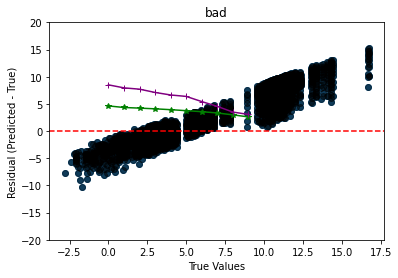

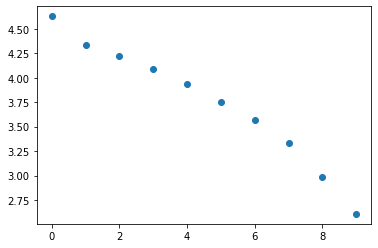

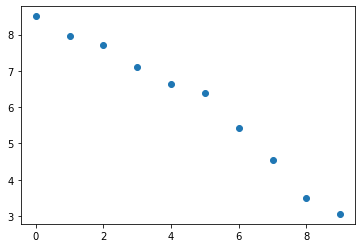

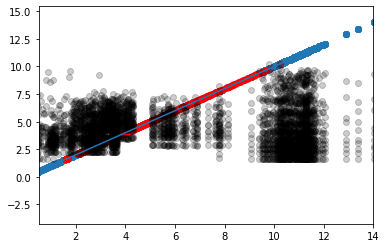

In [378]:
import torch
import torch.nn as nn

class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        # In self-attention, query, key, and value are all the same.
        attn_output, attn_weights = self.multihead_attn(x, x, x)
        return attn_output, attn_weights

# Example usage:
batch_size = 2
seq_length = 5
embed_dim = 16
num_heads = 4

# Create a random tensor in the expected shape: (seq_length, batch_size, embed_dim)
x = torch.randn(seq_length, batch_size, embed_dim)
mha = SimpleMultiheadAttention(embed_dim, num_heads)
output, weights = mha(x)
print("Multihead Attention Output Shape:", output.shape)   # (5, 2, 16)
print("Multihead Attention Weights Shape:", weights.shape)   # (2*num_heads, 5, 5)


array([-0.0298245])

Text(0.5, 1.0, 'lr 0.01 400 epochs dim2 depth 3 from 2 to end bc immediatelz went down')

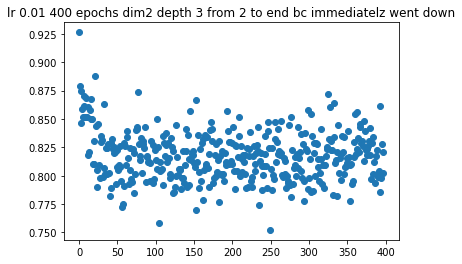

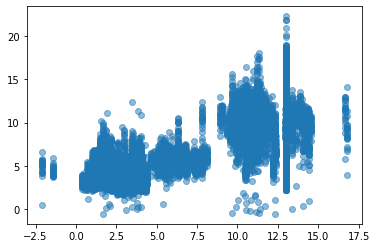

In [162]:
plt.scatter(ts, ps, alpha=0.5)

In [62]:
len(Ds.keys())
#Fails = fails
for i,j in fails.items():
    print(len(j))
for a in results.values():
    print(len(a))

20

In [40]:
len(all_data["10gs"]["pos"])

106

In [68]:
Ds.keys()

dict_keys(['10gs', '109l', '111m', '110m', '108m', '110l', '109m', '111l', '108l', '104m', '106m', '105m', '103m', '107m', '107l', '103l', '102m', '102l', '101m', '104l'])

In [ ]:
a=[]
for i in range(20):
    print(([(k[4], k[1][:3]) for k in results[i] ]))
    
    print(np.mean([k[4] for k in results[i] ]))
    #a.append(k[4] for k in results[i])


print(a)